<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Position-space" data-toc-modified-id="Position-space-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Position space</a></span><ul class="toc-item"><li><span><a href="#Translation-of-COM-instead-of-rotation-around-origin" data-toc-modified-id="Translation-of-COM-instead-of-rotation-around-origin-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Translation of COM instead of rotation around origin</a></span></li><li><span><a href="#Determine-position-index" data-toc-modified-id="Determine-position-index-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Determine position index</a></span></li></ul></li><li><span><a href="#Orientation-space" data-toc-modified-id="Orientation-space-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Orientation space</a></span><ul class="toc-item"><li><span><a href="#Determine-internal-coordinate-system-(principal-axes)" data-toc-modified-id="Determine-internal-coordinate-system-(principal-axes)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Determine internal coordinate system (principal axes)</a></span></li><li><span><a href="#Realize-that-determining-principal-axes-isn't-sufficient" data-toc-modified-id="Realize-that-determining-principal-axes-isn't-sufficient-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Realize that determining principal axes isn't sufficient</a></span></li><li><span><a href="#Quaternion-index" data-toc-modified-id="Quaternion-index-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Quaternion index</a></span></li></ul></li><li><span><a href="#Full-conversion-3N-coordinates-<->-7D-gridpoint" data-toc-modified-id="Full-conversion-3N-coordinates-<->-7D-gridpoint-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Full conversion 3N coordinates &lt;-&gt; 7D gridpoint</a></span></li><li><span><a href="#MSM" data-toc-modified-id="MSM-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>MSM</a></span></li></ul></div>

In [1]:
import sys
import os

try:
    os.chdir(r"/home/hanaz63/PAPER_MOLECULAR_ROTATIONS_2022/nobackup/molgri")
    sys.path.append(r"/home/hanaz63/PAPER_MOLECULAR_ROTATIONS_2022/nobackup")
except FileNotFoundError:
    os.chdir(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")
    sys.path.append(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")
    
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
from numpy.typing import NDArray
import MDAnalysis as mda
from scipy.spatial.distance import cdist
from scipy.spatial.transform import Rotation
from MDAnalysis.analysis.base import AnalysisFromFunction
import seaborn as sns

from molgri.plotting.widgets import ViewManager
from molgri.paths import PATH_OUTPUT_PT, PATH_INPUT_BASEGRO
from molgri.space.fullgrid import FullGrid
from molgri.space.utils import normalise_vectors, k_argmax_in_array, distance_between_quaternions, q_in_upper_sphere
from molgri.molecules.transitions import MSM, SimulationHistogram
from molgri.plotting.transition_plots import TransitionPlot

sns.set_context("notebook")

## Position space



### Translation of COM instead of rotation around origin

In [4]:
# generated a file with
# python -m molgri.scripts.generate_pt -m1 H2O -m2 H2O -o "12" -b "8" -t "linspace(0.2, 1, 5)" --recal
pt_name = "H2O_H2O_0528"
pt_universe = mda.Universe(f"{PATH_OUTPUT_PT}{pt_name}.gro",
                           f"{PATH_OUTPUT_PT}{pt_name}.trr")
len_pt = len(pt_universe.trajectory)

vm = ViewManager(pt_universe)
# plot every 8th frame
# because we have 8 orientations, every 8th structure should be translated version of each other
every_eighth_0 = np.arange(0, len_pt, 8)
print(list(every_eighth_0))
vm.plot_frames_overlapping(every_eighth_0[20:30])

[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200, 208, 216, 224, 232, 240, 248, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336, 344, 352, 360, 368, 376, 384, 392, 400, 408, 416, 424, 432, 440, 448, 456, 464, 472]


NGLWidget()

In [5]:
vm.fresh_view()
every_eighth_3 = np.arange(3, len_pt, 8)
# similar thing for another class of identical orientations
print(list(every_eighth_3))
vm.plot_frames_overlapping(every_eighth_3[20:30])

[3, 11, 19, 27, 35, 43, 51, 59, 67, 75, 83, 91, 99, 107, 115, 123, 131, 139, 147, 155, 163, 171, 179, 187, 195, 203, 211, 219, 227, 235, 243, 251, 259, 267, 275, 283, 291, 299, 307, 315, 323, 331, 339, 347, 355, 363, 371, 379, 387, 395, 403, 411, 419, 427, 435, 443, 451, 459, 467, 475]


NGLWidget()

### Determine position index

In [6]:
# separately determine index in the radial direction and on the sphere, then combine

def assign_2_t_grid(my_trajectory: mda.Universe, t_grid_points: NDArray,
                         second_molecule: str) -> NDArray:
    """
    Given a trajectoryand an array of available radial (t-grid) points, assign each frame of the trajectory
    to the closest radial point.
    
    Args:
        my_trajectory: a Universe of two molecules
        radial_grid_points: a sorted array of available radial grid distances in A like [2, 4, 6]
        second_molecule: a string that tdefines which part of the Universe is a moving molecule
    
    Returns:
        an integer array as long as the trajectory, each element an index of the closest point of the radial grid
        like [0, 0, 0, 1, 1, 1, 2 ...] (for a PT with 3 orientations)
    """
    t_selection = AnalysisFromFunction(lambda ag: np.argmin(np.abs(t_grid_points-np.linalg.norm(ag.center_of_mass())), axis=0),
                                     my_trajectory.trajectory,
                                     my_trajectory.select_atoms(second_molecule))
    t_selection.run()
    t_indices = t_selection.results['timeseries'].flatten()
    return t_indices

def assign_2_o_grid(my_trajectory: mda.Universe, o_grid_points: NDArray, 
                           second_molecule: str) -> NDArray:
    """
    Assign every frame of the trajectory (or PT) to the best fitting point of position grid

    Returns:
        an array of position grid indices
    """
    # now using a normalized com and a metric on a sphere, determine which of o_grid_points is closest
    o_selection = AnalysisFromFunction(lambda ag: np.argmin(cdist(o_grid_points, normalise_vectors(
        ag.center_of_mass())[np.newaxis, :], metric="cos"), axis=0),
                                     my_trajectory.trajectory,
                                     my_trajectory.select_atoms(second_molecule))
    o_selection.run()
    o_indices = o_selection.results['timeseries'].flatten()
    return o_indices

def assign_2_position_grid(my_trajectory: mda.Universe, o_grid_points: NDArray, t_grid_points: NDArray,
                         second_molecule: str):
    """
    Combine assigning to t_grid and o_grid.
    """
    t_assignments = assign_2_t_grid(my_trajectory=my_trajectory, t_grid_points=t_grid_points, 
                                    second_molecule=second_molecule)
    o_assignments = assign_2_o_grid(my_trajectory=my_trajectory, o_grid_points=o_grid_points,
                                   second_molecule=second_molecule)
    # sum up the layer index and o index correctly
    return np.array(t_assignments * len(o_grid_points) + o_assignments, dtype=int)


In [7]:
# test with a PT

my_second_molecule = "bynum 4:6"
my_full_grid = FullGrid(b_grid_name="8", o_grid_name="12", t_grid_name="linspace(0.2, 1, 5)")
position_assignments = assign_2_position_grid(pt_universe, my_full_grid.get_o_grid().get_grid_as_array(), 
                       my_full_grid.get_radii(), my_second_molecule)
print(position_assignments)
# test: a PT should have the first 8 elements in position 0, then 8 in position 1 ...
expected_assignments = np.repeat(np.arange(12*5), 8)
assert np.all(position_assignments == expected_assignments)

[ 0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2
  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8
  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14
 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17
 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20
 21 21 21 21 21 21 21 21 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23
 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26
 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28 29 29 29 29 29 29 29 29
 30 30 30 30 30 30 30 30 31 31 31 31 31 31 31 31 32 32 32 32 32 32 32 32
 33 33 33 33 33 33 33 33 34 34 34 34 34 34 34 34 35 35 35 35 35 35 35 35
 36 36 36 36 36 36 36 36 37 37 37 37 37 37 37 37 38 38 38 38 38 38 38 38
 39 39 39 39 39 39 39 39 40 40 40 40 40 40 40 40 41

In [8]:
# test with a real trajectory: see how long it takes
gro_name = "H2O_H2O_0095"
traj_name = "H2O_H2O_0095_25000"
traj_universe = mda.Universe(f"{PATH_OUTPUT_PT}{gro_name}.gro", f"{PATH_OUTPUT_PT}{traj_name}.xtc")

print(f"Assigning 25000 frames to 25x20={25*20} positions")
traj_full_grid = FullGrid(b_grid_name="20", o_grid_name="25", t_grid_name="linspace(0.2, 1.5, 20)")
position_assignments = assign_2_position_grid(traj_universe, traj_full_grid.get_o_grid().get_grid_as_array(), 
                       traj_full_grid.get_radii(), my_second_molecule)

Assigning 25000 frames to 25x20=500 positions


Most popular assignments are [477  68  28  27  48  31  38  26  33  51] with population [328 336 350 384 350 407 392 457 344 350]


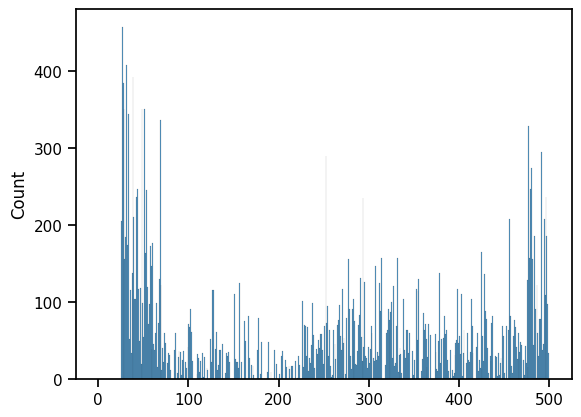

In [9]:
# make a histogram of most populated positions
sns.histplot(position_assignments, stat="count", bins=np.arange(501))

popular, counts = np.unique(position_assignments, return_counts=True)
max_counts = k_argmax_in_array(counts, 10)
print(f"Most popular assignments are {popular[max_counts]} with population {counts[max_counts]}")

In [10]:
# plot some frames of a real trajectory that belong to the same position grid point
vm = ViewManager(traj_universe)
# plot a selection (because too many) that are all assigned to grid point 26
assigned_to_26 = np.where(position_assignments == 26)[0]
# show in VMD for a better view
print(list(assigned_to_26))
vm.plot_frames_overlapping(np.random.choice(assigned_to_26, 30))

[854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2632, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4602, 4603, 4604, 4605, 4606, 4971, 4972, 4973, 4974, 4975, 4976, 4977, 4978, 4979, 4980, 4981, 4982, 4983, 4984, 4985, 4986, 4987, 4988, 4989, 4990, 4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999, 5000, 5001, 5002, 5003, 5004, 5005, 5006, 5007, 5008, 5009, 5010, 5011, 5012, 5013, 5014, 5015, 5016, 5017, 5018, 5019, 5020, 5021, 

NGLWidget()

In [11]:
# try another one
vm.fresh_view()
# plot a selection (because too many) that are all assigned to grid point 477
assigned_to_477 = np.where(position_assignments == 477)[0]
# show in VMD for a better view
print(list(assigned_to_477))
vm.plot_frames_overlapping(np.random.choice(assigned_to_477, 30))

[16795, 16796, 16797, 16798, 16799, 16800, 16801, 16802, 16803, 16804, 16805, 16806, 16807, 16808, 16809, 16810, 16811, 16812, 16813, 16814, 16815, 16816, 16817, 16818, 16819, 16820, 16821, 16822, 16823, 16824, 16825, 16826, 16827, 16828, 16829, 16830, 16831, 16832, 16833, 16834, 16835, 16836, 16837, 16838, 16839, 16840, 16841, 16842, 16843, 16844, 16845, 16846, 16847, 16848, 16849, 16850, 16851, 16852, 16853, 16854, 16855, 16856, 16857, 16858, 16859, 16860, 16861, 16862, 16863, 16864, 16865, 16866, 16867, 16868, 16869, 16870, 16871, 16872, 16873, 16874, 16875, 16876, 16877, 16878, 16879, 16880, 16881, 16882, 16883, 16884, 16885, 16886, 16887, 16888, 16889, 16890, 16891, 16892, 16893, 16894, 16895, 16896, 16897, 16898, 16899, 16900, 16901, 16902, 16903, 16904, 16905, 16906, 16907, 16908, 16909, 17106, 17107, 17108, 17109, 17110, 17111, 17112, 17113, 17114, 17115, 17116, 17117, 17118, 17119, 17120, 17121, 17122, 17123, 17124, 17342, 17343, 17344, 17345, 17346, 17347, 17348, 17349, 17350

NGLWidget()

## Orientation space

### Determine internal coordinate system (principal axes)

In [12]:
# determine principal axes
second_molecule = "bynum 4:6"

# principal axes of the first frame
pa_zero = pt_universe.select_atoms(second_molecule).principal_axes()
com_zero = pt_universe.select_atoms(second_molecule).center_of_mass()
print(np.round(pa_zero, 3))
print(com_zero+pa_zero[0])

# display principal axes of first frame
vm = ViewManager(pt_universe)
vm.fresh_view()
vm.plot_ith_frame(0)
vm.add_principal_axes(com_zero, pa_zero)
vm.view



[[ 0.     1.     0.   ]
 [-0.599  0.    -0.8  ]
 [-0.8    0.     0.599]]
[-1.70130157  1.          1.0514622 ]


NGLWidget()

In [13]:
vm.fresh_view()

# principal axes change in relation to the stationary coordinate system when the molecule is re-oriented
# but they remain the same in relation to the molecule itself

# using some selected PT frames for demonstration
for i in [20, 63, 284]:
    pt_universe.trajectory[i]
    pa_current = pt_universe.select_atoms(second_molecule).principal_axes()
    com_current = pt_universe.select_atoms(second_molecule).center_of_mass()
    print(np.round(pa_current, 3))

    # display this
    vm.plot_ith_frame(i)
    vm.add_principal_axes(com_current, pa_current)
vm.view

[[-0.     0.     1.   ]
 [ 0.8   -0.599  0.   ]
 [ 0.599  0.8    0.   ]]
[[-0.    -0.     1.   ]
 [ 0.8    0.599  0.   ]
 [-0.599  0.8    0.   ]]
[[ 0.     0.     1.   ]
 [ 0.8   -0.599  0.   ]
 [ 0.599  0.8    0.   ]]


NGLWidget()

... well, almost the same

### Realize that determining principal axes isn't sufficient

In [14]:
# LESSION LEARNED: principal axes are axes and NOT vectors - their direction is NOT clearly defined
# see also: https://math.stackexchange.com/questions/145023/rotation-matrix-from-an-inertia-tensor

# python -m molgri.scripts.generate_pt -m1 H2O -m2 H2O -o "1" -b "20" -t "1" --recal
from molgri.space.rotobj import SphereGrid4DFactory
b_selection = SphereGrid4DFactory().create(alg_name="cube4D", N=20).get_grid_as_array()
b_universe = mda.Universe(f"{PATH_OUTPUT_PT}H2O_H2O_0407.gro", f"{PATH_OUTPUT_PT}H2O_H2O_0407.xtc")

vm = ViewManager(b_universe)
vm.fresh_view()
reference_structure = mda.Universe(f"{PATH_INPUT_BASEGRO}H2O.gro")
reference_principal_axes = reference_structure.atoms.principal_axes()

for i in range(17, 18):
    b_universe.trajectory[i]
    reference_structure = mda.Universe(f"{PATH_INPUT_BASEGRO}H2O.gro")
    reference_principal_axes = reference_structure.atoms.principal_axes()
    my_R = Rotation(b_selection[i]).as_matrix()
    expected_pa = Rotation(b_selection[i]).apply(reference_principal_axes)
    #expected_pa = (my_R @ reference_principal_axes.T).T

    print("my R @ ref", np.round(expected_pa, 3))

    current_principal_axes = b_universe.select_atoms(second_molecule).principal_axes()
    com_current = b_universe.select_atoms(second_molecule).center_of_mass()
    print("end_pa", np.round(current_principal_axes, 3))
    vm.plot_ith_frame(i)
    vm.add_principal_axes(com_current, expected_pa)
    vm.add_principal_axes(com_current, current_principal_axes)
vm.view

my R @ ref [[ 0.     0.    -1.   ]
 [-0.599  0.8    0.   ]
 [ 0.8    0.599  0.   ]]
end_pa [[ 0.    -0.     1.   ]
 [ 0.599 -0.8   -0.   ]
 [ 0.8    0.599 -0.   ]]


NGLWidget()

In [15]:
# LESSONS LEARNED
# 1. symmetry of water is a problem
# 2. need to save in a higher precision file trr
# 3. need to round structures read from files otherwise values very close to zero can throw off 
#    quaternion projection to correct hemisphere

def determine_positive_directions(current_universe, second_molecule):
    pas = current_universe.select_atoms(second_molecule).principal_axes()
    com = current_universe.select_atoms(second_molecule).center_of_mass()
    directions = [0, 0, 0]
    for atom_pos in current_universe.select_atoms(second_molecule).positions:
        for i, pa in enumerate(pas):
            # need to round to avoid problems - assigning direction with atoms very close to 0
            cosalpha = np.round(pa.dot(atom_pos-com), 6)
            directions[i] = np.sign(cosalpha)
        if not np.any(np.isclose(directions,0)):
            break
    # TODO: if exactly one unknown use the other two and properties of righthanded systems to get third
    if np.sum(np.isclose(directions,0)) == 1:
        # only these combinations of directions are possible in righthanded coordinate systems
        allowed_righthanded = [[1, 1, 1], [-1, 1, -1], [1, -1, -1], [-1, -1, 1]]
        for ar in allowed_righthanded:
            # exactly two identical (and the third is zero)
            if np.sum(np.isclose(ar, directions)) == 2:
                directions = ar
                break
    # if two (or three - that would just be an atom) unknowns raise an error
    elif np.sum(np.isclose(directions,0)) > 1:
        raise ValueError("All atoms perpendicular to at least one of principal axes, can´t determine direction.")
    return np.array(directions)

# saved PT
my_new_u = mda.Universe(f"{PATH_OUTPUT_PT}glucose_glucose_0025.gro", f"{PATH_OUTPUT_PT}glucose_glucose_0025.trr")
b_selection = SphereGrid4DFactory().create(alg_name="cube4D", N=20).get_grid_as_array()
second_molecule_glu = "bynum 13:24"

# reference structure
reference_structure = mda.Universe(f"{PATH_INPUT_BASEGRO}glucose.xyz")
second_molecule_ref = "bynum 1:12"
reference_principal_axes = reference_structure.atoms.principal_axes().T
inverse_pa = np.linalg.inv(reference_principal_axes)
reference_direction = determine_positive_directions(reference_structure, second_molecule_ref)

# frame 0: q3 in direction C-O, frame 1: q3 in direction O
for i in range(20):
    my_new_u.trajectory[i]
    com_current = my_new_u.select_atoms(second_molecule_glu).center_of_mass()
    current_principal_axes = my_new_u.select_atoms(second_molecule_glu).principal_axes().T
    current_directions = determine_positive_directions(my_new_u, second_molecule_glu)
    direction = current_directions * reference_direction
    produkt = np.multiply(current_principal_axes, np.tile(direction, (3, 1))) @ inverse_pa
    calc_quat = np.round(Rotation.from_matrix(produkt).as_quat(), 6) 
    if not q_in_upper_sphere(calc_quat):
        calc_quat = -calc_quat
    print(current_directions)
    print(np.allclose(b_selection[i], calc_quat, atol=1e-5, rtol=1e-5), b_selection[i], calc_quat)

[-1.  1. -1.]
True [ 0.5 -0.5 -0.5  0.5] [ 0.5 -0.5 -0.5  0.5]
[1. 1. 1.]
True [ 0.5 -0.5  0.5 -0.5] [ 0.5 -0.5  0.5 -0.5]
[ 1. -1. -1.]
True [0.5 0.5 0.5 0.5] [0.5 0.5 0.5 0.5]
[1. 1. 1.]
True [ 0.5  0.5 -0.5  0.5] [ 0.5  0.5 -0.5  0.5]
[-1. -1.  1.]
True [ 0.5 -0.5  0.5  0.5] [ 0.5 -0.5  0.5  0.5]
[ 1. -1. -1.]
True [ 0.5  0.5  0.5 -0.5] [ 0.5  0.5  0.5 -0.5]
[-1. -1.  1.]
True [ 0.5  0.5 -0.5 -0.5] [ 0.5  0.5 -0.5 -0.5]
[-1.  1. -1.]
True [ 0.5 -0.5 -0.5 -0.5] [ 0.5 -0.5 -0.5 -0.5]
[ 1. -1. -1.]
True [ 0.57735027 -0.57735027  0.          0.57735027] [ 0.57735 -0.57735  0.       0.57735]
[1. 1. 1.]
True [0.70710678 0.70710678 0.         0.        ] [ 0.707107  0.707107  0.       -0.      ]
[-1. -1.  1.]
True [0.         0.         0.70710678 0.70710678] [-0.        0.        0.707107  0.707107]
[1. 1. 1.]
True [0.70710678 0.         0.70710678 0.        ] [0.707107 0.       0.707107 0.      ]
[1. 1. 1.]
True [ 0.          0.57735027  0.57735027 -0.57735027] [ 0.       0.57735  0.5773

In [16]:
#python -m molgri.scripts.generate_pt -m1 H2O_a -m2 H2O_a -o "1" -b "20" -t "0.3" --recal --extension_structure gro --extension_trajectory trr


# saved PT
my_new_u = mda.Universe(f"{PATH_OUTPUT_PT}H2O_a_H2O_a_0000.gro", f"{PATH_OUTPUT_PT}H2O_a_H2O_a_0000.trr")
b_selection = SphereGrid4DFactory().create(alg_name="cube4D", N=20).get_grid_as_array()
second_molecule_glu = "bynum 4:6"

# reference structure
reference_structure = mda.Universe(f"{PATH_INPUT_BASEGRO}H2O_a.gro")
second_molecule_ref = "bynum 1:3"
reference_principal_axes = reference_structure.atoms.principal_axes().T
inverse_pa = np.linalg.inv(reference_principal_axes)
reference_direction = determine_positive_directions(reference_structure, second_molecule_ref)

# frame 0: q3 in direction C-O, frame 1: q3 in direction O
for i in range(20):
    my_new_u.trajectory[i]
    com_current = my_new_u.select_atoms(second_molecule_glu).center_of_mass()
    current_principal_axes = my_new_u.select_atoms(second_molecule_glu).principal_axes().T
    current_directions = determine_positive_directions(my_new_u, second_molecule_glu)
    direction = current_directions * reference_direction
    produkt = np.multiply(current_principal_axes, np.tile(direction, (3, 1))) @ inverse_pa
    calc_quat = np.round(Rotation.from_matrix(produkt).as_quat(), 6) 
    if not q_in_upper_sphere(calc_quat):
        calc_quat = -calc_quat
    print(np.allclose(b_selection[i], calc_quat, atol=1e-6, rtol=1e-5), b_selection[i], calc_quat)

True [ 0.5 -0.5 -0.5  0.5] [ 0.5 -0.5 -0.5  0.5]
True [ 0.5 -0.5  0.5 -0.5] [ 0.5 -0.5  0.5 -0.5]
True [0.5 0.5 0.5 0.5] [0.5 0.5 0.5 0.5]
True [ 0.5  0.5 -0.5  0.5] [ 0.5  0.5 -0.5  0.5]
True [ 0.5 -0.5  0.5  0.5] [ 0.5 -0.5  0.5  0.5]
True [ 0.5  0.5  0.5 -0.5] [ 0.5  0.5  0.5 -0.5]
True [ 0.5  0.5 -0.5 -0.5] [ 0.5  0.5 -0.5 -0.5]
True [ 0.5 -0.5 -0.5 -0.5] [ 0.5 -0.5 -0.5 -0.5]
True [ 0.57735027 -0.57735027  0.          0.57735027] [ 0.57735 -0.57735  0.       0.57735]
True [0.70710678 0.70710678 0.         0.        ] [ 0.707107  0.707107 -0.       -0.      ]
True [0.         0.         0.70710678 0.70710678] [-0.       -0.        0.707107  0.707107]
True [0.70710678 0.         0.70710678 0.        ] [ 0.707107 -0.        0.707107 -0.      ]
True [ 0.          0.57735027  0.57735027 -0.57735027] [ 0.       0.57735  0.57735 -0.57735]
True [ 0.70710678  0.          0.         -0.70710678] [ 0.707107 -0.       -0.       -0.707107]
True [ 0.57735027  0.          0.57735027 -0.57735027]

In summary:
- save and use (pseudo)trajectories in high-precision TRR format
- determine principal axes of the reference structure and every frame of the PT
- determine direction of each PA from the coordinates of the first atom that isn't perpendicular to it
- if a molecule is planar, you can still determine directions from right-handedness of PAs

TODO:
- now assign to gridpoints
- need a better symmetry handling for linear molecules

### Quaternion index

In [17]:
def assign_2_b_grid(my_trajectory: mda.Universe, b_grid_points: NDArray, reference_universe: mda.Universe,
                           second_molecule: str) -> NDArray:
    """
    Assign every frame of the trajectory to the closest quaternion from the b_grid_points.
    
    Args:
        my_trajectory: consists of two molecules and multiple frames
        b_grid_points: a (N, 4) array of unit quaternions
        reference_universe: consists of only one molecule in a single frame
        second_molecule: defines which molecule interests us in my_trajectory
    """
    # find PA and direction of reference structure
    reference_principal_axes = reference_universe.atoms.principal_axes().T
    inverse_pa = np.linalg.inv(reference_principal_axes)
    reference_direction = determine_positive_directions(reference_universe, "all")
    
    # find PA and direction along trajectory
    pa_frames =  AnalysisFromFunction(lambda ag: ag.principal_axes().T, my_trajectory.trajectory,
                                     my_trajectory.select_atoms(second_molecule))
    pa_frames.run()
    pa_frames = pa_frames.results['timeseries']
    
    direction_frames = AnalysisFromFunction(lambda ag: np.tile(determine_positive_directions(ag, "all"), (3, 1)), 
                                            my_trajectory.trajectory,
                                            my_trajectory.select_atoms(second_molecule))
    direction_frames.run()
    direction_frames = direction_frames.results['timeseries']
    directed_pas = np.multiply(pa_frames, direction_frames)
    produkt = np.matmul(directed_pas, inverse_pa)
    # get the quaternions that caused the rotation from reference to each frame
    calc_quat = np.round(Rotation.from_matrix(produkt).as_quat(), 6)
    # now using a quaternion metric, determine which of b_grid_points is closest

    b_indices = np.argmin(cdist(b_grid_points, calc_quat, metric=distance_between_quaternions), axis=0)
    # almost everything correct but the order is somehow mixed???
    return b_indices

# water PT example
H2O_pt_name = "H2O_H2O_0528"
H2O_pt_universe = mda.Universe(f"{PATH_OUTPUT_PT}{H2O_pt_name}.gro",
                           f"{PATH_OUTPUT_PT}{H2O_pt_name}.trr")
H2O_second_mol = "bynum 4:6"
H2O_reference_universe = mda.Universe(f"{PATH_INPUT_BASEGRO}H2O.gro")
H2O_full_grid = FullGrid(b_grid_name="8", o_grid_name="12", t_grid_name="linspace(0.2, 1, 5)", use_saved=False)
H2O_b_grid = my_full_grid.b_rotations.get_grid_as_array()
                                      
assignments_quaternion_pt = assign_2_b_grid(H2O_pt_universe, H2O_b_grid, H2O_reference_universe, H2O_second_mol)
print(assignments_quaternion_pt)
vm = ViewManager(H2O_pt_universe)
# plot a selection (because too many) that are all assigned to grid point 21
assigned_to_26 = np.where(assignments_quaternion_pt == 1)[0]
# show in VMD for a better view
print(list(assigned_to_26))
vm.plot_frames_overlapping(np.random.choice(assigned_to_26, 30))

[1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5
 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0
 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2
 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7
 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1
 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4
 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6
 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3
 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5
 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0
 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2
 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7
 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3 1 0 6 7 5 4 2 3]
[0, 8, 16, 24, 32, 40, 48,

NGLWidget()

In [18]:
# test with a real trajectory: see how long it takes
gro_name = "H2O_H2O_0095"
traj_name = "H2O_H2O_0095_25000"
b_selection = SphereGrid4DFactory().create(alg_name="cube4D", N=80).get_grid_as_array()
traj_universe = mda.Universe(f"{PATH_OUTPUT_PT}H2O_H2O_0095.gro", f"{PATH_OUTPUT_PT}H2O_H2O_0095_25000.xtc")

print(f"Assigning 25000 frames to 80 quaternions")
print(b_selection)

quaternion_assignments = assign_2_b_grid(traj_universe, b_selection, H2O_reference_universe, H2O_second_mol)

Assigning 25000 frames to 80 quaternions
[[ 0.5        -0.5        -0.5         0.5       ]
 [ 0.5        -0.5         0.5        -0.5       ]
 [ 0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5        -0.5         0.5       ]
 [ 0.5        -0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5        -0.5       ]
 [ 0.5         0.5        -0.5        -0.5       ]
 [ 0.5        -0.5        -0.5        -0.5       ]
 [ 0.57735027 -0.57735027  0.          0.57735027]
 [ 0.70710678  0.70710678  0.          0.        ]
 [ 0.          0.          0.70710678  0.70710678]
 [ 0.70710678  0.          0.70710678  0.        ]
 [ 0.          0.57735027  0.57735027 -0.57735027]
 [ 0.70710678  0.          0.         -0.70710678]
 [ 0.57735027  0.          0.57735027 -0.57735027]
 [ 0.57735027  0.57735027  0.         -0.57735027]
 [ 0.57735027  0.          0.57735027  0.57735027]
 [ 0.70710678  0.         -0.70710678  0.        ]
 [ 0.57735027  0.57735027 -0.57735027  0.

Most popular assignments are [20 33 32] with population [ 644  817 1103]


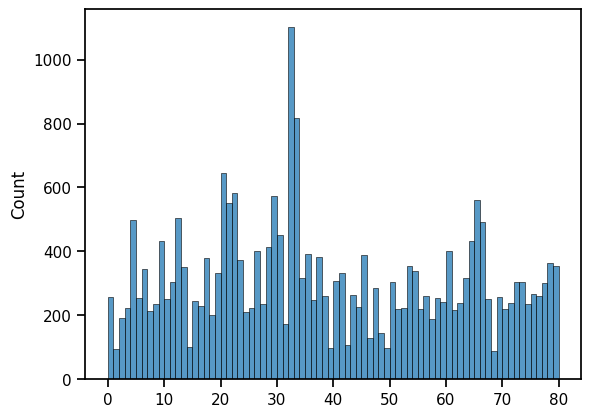

In [19]:
# make a histogram of most populated quaternions
sns.histplot(quaternion_assignments, stat="count", bins=np.arange(81))

popular, counts = np.unique(quaternion_assignments, return_counts=True)
max_counts = k_argmax_in_array(counts, 3)
print(f"Most popular assignments are {popular[max_counts]} with population {counts[max_counts]}")

In [20]:
# plot some frames of a real trajectory that belong to the same quaternion grid point
vm = ViewManager(traj_universe)
# plot a selection (because too many) that are all assigned to grid point 21
assigned_to_26 = np.where(quaternion_assignments == 15)[0]
# show in VMD for a better view
print(list(assigned_to_26))
vm.plot_frames_overlapping(np.random.choice(assigned_to_26, 30))

[1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4067, 4068, 4069, 4438, 4439, 4440, 4441, 4442, 4443, 4444, 4445, 4446, 4447, 4448, 4449, 4450, 5702, 5703, 5704, 5705, 5706, 6892, 6893, 6894, 6895, 6896, 6897, 6898, 7018, 7019, 7020, 7021, 7022, 7023, 7024, 7025, 7026, 7027, 7028, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 9658, 9659, 9660, 9661, 9662, 9663, 9664, 9665, 9956, 9957, 9958, 9959, 9960, 9961, 9962, 9963, 9964, 9965, 9966, 9967, 9968, 9969, 9970, 9971, 9972, 11750, 11751, 11752, 11753, 11754, 11755, 11756, 11757, 11758, 11759, 11760, 11761, 11762, 11763, 12324, 12325, 12326, 12327, 12328, 12329, 12330, 12331, 12332

NGLWidget()

## Full conversion 3N coordinates <-> 7D gridpoint

In [ ]:
def full_assignment(position_assignment, quaternion_assignment, num_quaternions):
    return position_assignment*num_quaternions + quaternion_assignment

fg = FullGrid(b_grid_name="40", o_grid_name="42", t_grid_name="linspace(0.2, 1, 20)")
b_grid = fg.b_rotations.get_grid_as_array()
o_grid = fg.get_o_grid().get_grid_as_array()
t_grid = fg.get_radii()

position_assignments = assign_2_position_grid(traj_universe, o_grid, 
                       t_grid, H2O_second_mol)
quaternion_assignments = assign_2_b_grid(traj_universe, b_grid, H2O_reference_universe, H2O_second_mol)

full_assignments = full_assignment(position_assignments, quaternion_assignments, len(b_grid))

In [ ]:
# make a histogram of most populated full grid cells
sns.histplot(full_assignments, stat="count", bins=np.arange(len(fg)+1))

popular, counts = np.unique(full_assignments, return_counts=True)
max_counts = k_argmax_in_array(counts, 10)
print(f"Most popular assignments are {popular[max_counts]} with population {counts[max_counts]}")

In [ ]:
vm = ViewManager(traj_universe)
# plot a selection (because too many) that are all assigned to same grid point
assigned_to_cell = np.where(full_assignments == 3550)[0]
# show in VMD for a better view
print(list(assigned_to_cell))
vm.plot_frames_overlapping(np.random.choice(assigned_to_cell, 30))

In [ ]:
vm = ViewManager(traj_universe)
# plot a selection (because too many) that are all assigned to same grid point
assigned_to_cell = np.where(full_assignments == 4811)[0]
# show in VMD for a better view
print(list(assigned_to_cell))
vm.plot_frames_overlapping(np.random.choice(assigned_to_cell, 30))



## MSM

In [ ]:
fg = FullGrid(b_grid_name="40", o_grid_name="42", t_grid_name="linspace(0.2, 1, 20)")
water_sh = SimulationHistogram(trajectory_name="H2O_H2O_0095_25000", is_pt=False,
                               reference_name="H2O",
                               second_molecule_selection="bynum 4:6",
                               full_grid=fg, use_saved=False)

water_MSM = MSM(water_sh)
water_MSM.get_transitions_matrix()
water_MSM.get_eigenval_eigenvec(8)

In [ ]:
tp = TransitionPlot(water_sh)
tp.transition_obj.use_saved = True

tp.transition_obj.assignments = sh.full_grid.get_quaternion_index()
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))
tp.plot_eigenvalues(num_eigenv=5, index_tau=7, save=False, fig=fig, ax=ax[0])
tp.plot_its(5, as_line=False, save=False, fig=fig, ax=ax[1])
plt.show()

In [ ]:
fig, ax = plt.subplots(3, sharex=True, sharey=True)
for i in range(3):
    tp.plot_one_eigenvector_flat(i, save=False, fig=fig, ax=ax[i], index_tau=7)
plt.show()

In [83]:
# -> direction: INPUT start coordinates (3N), 7D gridpoint; OUTPUT end coordinates (3N)
# <- direction: INPUT end coordinates (3N), start coordinates (3N); OUTPUT 7D gridpoint